### Required imports

In [203]:
from arch import arch_model
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from pandas_datareader import DataReader
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from dsutils import adfuller_test, cointegration_test, invert_transformation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import warnings

# To ignore all warnings in model output
warnings.filterwarnings("ignore")


register_matplotlib_converters()
sns.set()
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Volatility Analysis

### 1- Model choice

Stock returns have an asymmetric shock. It is often the case. A piece of “bad news”, or a negative return, such as a drop in the stock price, reduces the value of equity relative to the fixed value of debt of that firm according to Enders (2014). The opposite effect will also be present – an increase in the stock price reduces leverage and risk. It is also often the case, that stocks move more often with the market when the market goes down than when it goes up(Yongmiao Hong et al. , The Review of Financial Studies, 2007). EGARCH model is well suited to model such asymmetric shocks. It adds a conditional component to model the asymmetry in shocks similar to the GJR-GARCH and it doesn't have a non-negative constraint on alpha and beta, making the model faster.

#### Plot of the returns

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Returns(%)')

Text(0.5, 1.0, 'AAPL Returns')

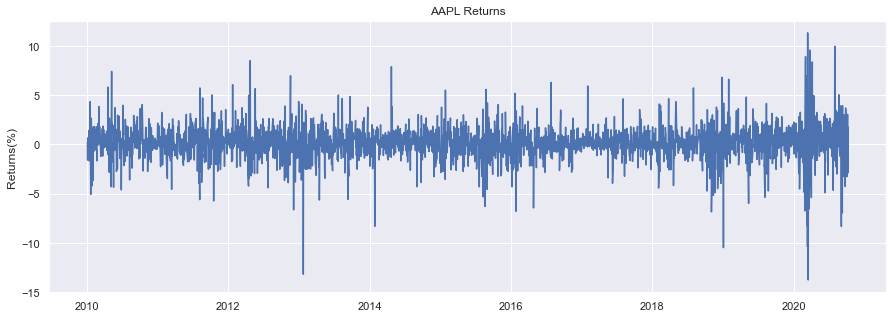

In [2]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2020, 10, 9)
aapl = DataReader("AAPL", "yahoo", start_date, end_date)
returns = pd.DataFrame(np.diff(np.log(aapl["Adj Close"].values)))
returns = 100 * returns
returns.index = aapl.index.values[1 : aapl.index.values.shape[0]]
returns.columns = ["AAPL Returns"]

plt.figure(figsize=(15, 5))
plt.plot(returns.index, returns)
plt.ylabel("Returns(%)")
plt.title("AAPL Returns")

One way to visualize the underlying volatility of the series is to plot the absolute returns ∣y∣:

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Absolute Returns(%)')

Text(0.5, 1.0, 'Apple Absolute Returns')

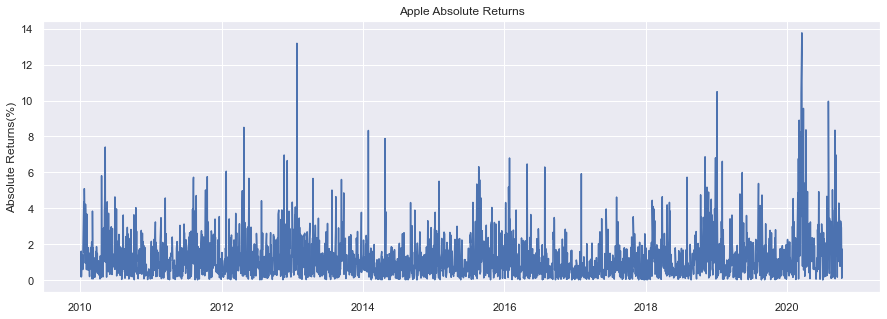

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel("Absolute Returns(%)")
plt.title("Apple Absolute Returns")

#### Model specification

Iteration:     10,   Func. Count:     99,   Neg. LLF: 4760.994056625304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4760.871301667804
            Iterations: 15
            Function evaluations: 140
            Gradient evaluations: 15
                             AR - EGARCH Model Results                              
Dep. Variable:                 AAPL Returns   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4760.87
Distribution:      Standardized Student's t   AIC:                           9533.74
Method:                  Maximum Likelihood   BIC:                           9568.96
                                              No. Observations:                 2618
Date:                      Tue, Oct 13 2020   Df Residuals:                     2612
Time:                              10

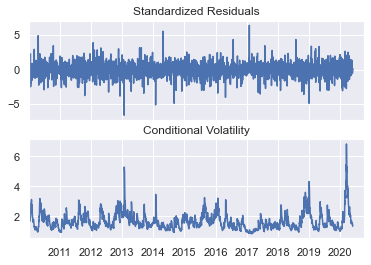

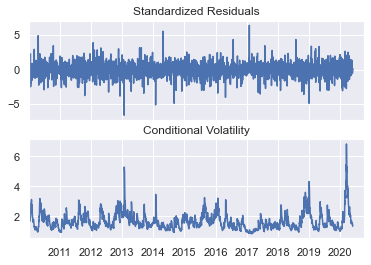

In [4]:
# Specify EGARCH model assumptions
basic_gm = arch_model(returns, p=1, q=1, o=1, mean="AR", vol="EGARCH", dist="t")
# Fit the model
split_date = datetime(2020, 6, 1)
gm_result = basic_gm.fit(update_freq=10, last_obs=split_date)

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot()
plt.show()

The coefficients are all significant at the 1% significant level as p-values for all coefficient is less than 1%. The abslolute value of the t-values are all greater than 2 as well. alpha is greater than 0.10 which indicates a spily market as clearly shown on the conditional volatility plot. beta is 0.94 which is in the high end for daily data according to Alexander(2008), meaning that the volatility has high persistency or otherwise stated, past volatility have high impact on current volatility.

#### Analysis of model residuals

(array([1.000e+00, 4.000e+00, 2.300e+01, 1.470e+02, 1.031e+03, 1.186e+03,
        2.020e+02, 1.800e+01, 4.000e+00, 2.000e+00]),
 array([-6.6010783 , -5.30090723, -4.00073615, -2.70056508, -1.40039401,
        -0.10022293,  1.19994814,  2.50011922,  3.80029029,  5.10046137,
         6.40063244]),
 <BarContainer object of 10 artists>)

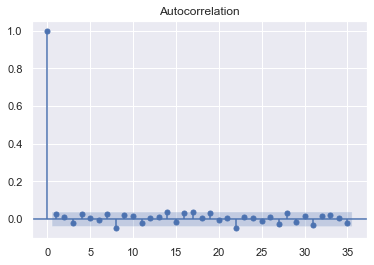

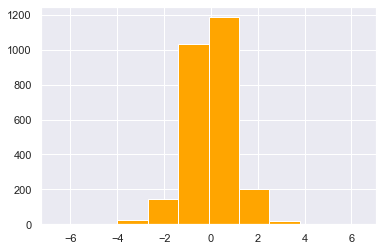

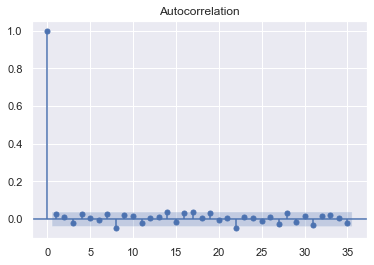

In [5]:
std_resid = gm_result.resid / gm_result.conditional_volatility
std_resid.dropna(inplace=True)
plt.hist(std_resid, facecolor="orange", label="standardized residuals")
plot_acf(std_resid, alpha=0.05)

In [6]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(std_resid, lags=10, return_df=True)
# Check p-values
lb_test.lb_pvalue

1     0.191196
2     0.377703
3     0.389669
4     0.318130
5     0.447848
6     0.552290
7     0.461829
8     0.093471
9     0.106428
10    0.122627
Name: lb_pvalue, dtype: float64

The pvalue of residuals up to lag 10 is greater than 0.01, so we accept the null hypothesis of residuals that are independently distributed, i.e, there is no autocorrelation in the residuals

The model will be estimated using the first 10 years and 4 months to estimate parameters and then forecasts will be produced for the final period in the sample.

### 2- One step ahead Forecast

In [7]:
# Make 1-period ahead forecast
gm_forecast = gm_result.forecast(method="simulation", start=split_date)

# Print the forecast variance
print(gm_forecast.mean[-1:])

                h.1
2020-10-09  0.12645


## Multivariate Analysis
### Equilibrium CAD/USD Exchange Rate

### 1- Describe the economic theories and models used to calculate equilibrium FX

### 2- Indicate macroeconomic variables used to determine the equilibrium FX

### 3- Explain the connection between linear regression and Vector Error Correction (VEC)
Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. One or more variable are considered to be independent variables, and one variable is considered to be a dependent variable.
The vector auto-regression is a system of regression which contains a set of `m` variables, each of which is expressed as a linear function of `p` lags of itself and of all of the other `m – 1` variables, plus an error term. Both linear regression and VAR use OLS to estimate paramters. When the variables of a VAR are cointegrated, we use a vector error-correction (VEC) which is a special case of VAR.

### 4- Calculate the equilibrium FX using VEC and comment all your results

#### Get relevant data

In [8]:
import os
import quandl

In [9]:
API_KEY = os.environ.get("quandl_api_key")
quandl.ApiConfig.api_key = API_KEY

CPI_CAN = quandl.get(
    "RATEINF/CPI_CAN",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
CPI_US = quandl.get(
    "RATEINF/CPI_USA",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
CAN_5Y = quandl.get(
    "BOC/V122540",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
US_5Y = quandl.get(
    "USTREASURY/REALYIELD",
    authtoken=API_KEY,
    column_index="1",
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)

In [17]:
CPI_CAN = quandl.get(
    "RATEINF/CPI_CAN",
    authtoken=API_KEY,
    start_date="2003-01-31",
    end_date="2020-08-31",
    collapse="monthly",
)
CPI_US = quandl.get(
    "RATEINF/CPI_USA",
    authtoken=API_KEY,
    start_date="2003-01-31",
    end_date="2020-08-31",
    collapse="monthly",
)
CAN_5Y = quandl.get(
    "BOC/V122540",
    authtoken=API_KEY,
    start_date="2003-01-31",
    end_date="2020-08-31",
    collapse="monthly",
)
US_5Y = quandl.get(
    "USTREASURY/REALYIELD",
    authtoken=API_KEY,
    column_index="1",
    start_date="2003-01-31",
    end_date="2020-08-31",
    collapse="monthly",
)

In [18]:
CPI_CAN.info()  # 1989-01-31 to 2020-08-31 (reduce it to 2003-01-31)
CPI_US.info()  # 1913-01-31 to 2020-08-31 (reduce it to 2003-01-31)
CAN_5Y.info()  # 2001-12-31 to 2020-09-30 (reduce it to 2020-08-31)
US_5Y.info()  #  (reduce it to 2020-08-31)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2003-01-31 to 2020-08-31
Data columns (total 1 columns):
Value    212 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2003-01-31 to 2020-08-31
Data columns (total 1 columns):
Value    212 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2003-01-31 to 2020-08-31
Data columns (total 1 columns):
Value    212 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2003-01-31 to 2020-08-31
Data columns (total 1 columns):
5 YR    212 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB


##### The FX data is a premium feature on Quandl so we used an alternative API.

In [15]:
url = "https://api.exchangeratesapi.io/history?start_at=2003-01-31&end_at=2020-08-31&symbols=CAD&base=USD"
response = requests.get(url)
data = response.json()
dates = sorted(data["rates"].keys())
dates = pd.to_datetime(dates)
exch_rates = []
for key_val in list(data["rates"].values()):
    exch_rates.append(key_val["CAD"])
exch_rate_data = {"FX": exch_rates}
USDCAD_daily = pd.DataFrame(data=exch_rate_data, index=dates)

# Transform the FX data to quarterly data
USDCAD = USDCAD_daily.resample("M").mean()

In [16]:
USDCAD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2003-01-31 to 2020-08-31
Freq: M
Data columns (total 1 columns):
FX    212 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB


In [19]:
# vecm_data = USDCAD.copy(deep=True)
vecm_data = pd.concat(
    [USDCAD, CPI_CAN, CPI_US, CAN_5Y, US_5Y],
    axis=1,
)
vecm_data.columns = ["FX", "CPI_CAN", "CPI_US", "CAN_5Y", "US_5Y"]

In [20]:
vecm_data.describe()

,FX,CPI_CAN,CPI_US,CAN_5Y,US_5Y
count,212.000000,212.000000,212.000000,212.000000,212.000000
mean,1.182546,119.736792,223.592311,2.337217,0.516132
std,0.030702,10.292180,21.790335,1.202930,1.042069
min,1.115468,102.000000,181.700000,0.320000,-1.490000
25%,1.161161,111.675000,207.941000,1.395000,-0.145000
50%,1.183618,120.650000,226.483000,2.050000,0.350000
75%,1.204919,128.000000,238.805750,3.525000,1.185000
max,1.312318,137.400000,259.918000,4.630000,4.170000


Because the PPP equation is expressed in terms of logarithm of prices and exchange rate, we create a new dataframe by turning these variables into their logarithm(ppp_df), but we do not change the scale of the UIRP(uirp_df), then we join both dataframes for our modelling

In [23]:
ppp_df = np.log(vecm_data.loc[:, ["FX", "CPI_CAN", "CPI_US"]])
uirp_df = vecm_data.loc[:, ["CAN_5Y", "US_5Y"]]
log_vecm = pd.concat([ppp_df, uirp_df], axis=1)
log_vecm.to_csv("log_vecm.csv")

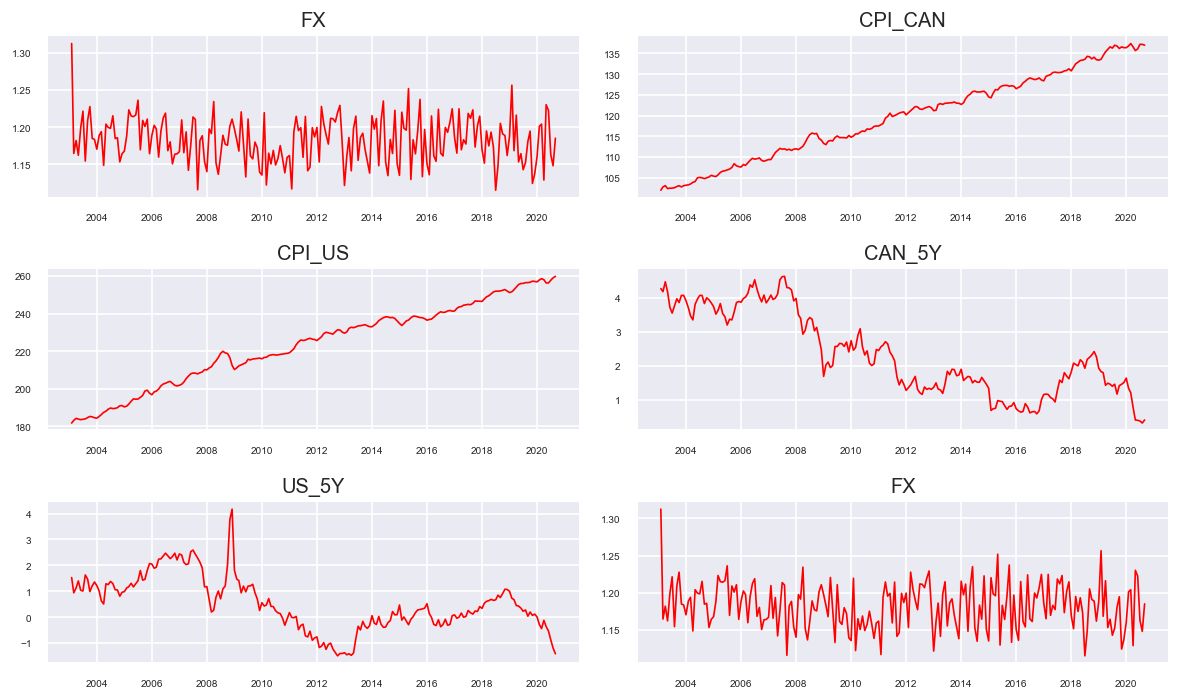

In [157]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten(), start=-5):
    data = vecm_data[vecm_data.columns[i]]
    ax.plot(data, color="red", linewidth=1)

    # Decorations
    ax.set_title(vecm_data.columns[i])
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

#### Comments
This plot shows clearly that FX is stationary while both CPI_US and CPI_CAN are trending upward and US_5Y and CAN_5Y are trending downward.
This means we need to get all series stationary before going forward with the modeling of the VAR

#### Split the data into train and test set

The VECM model will be fitted on df_train and then used to forecast the next 10 observations. These forecasts will be compared against the actuals present in test data.

In [159]:
nobs = 12
vecm_train, vecm_test = vecm_data.iloc[:-nobs], vecm_data.iloc[-nobs:]
# Check size
print(vecm_train.shape)  # (59, 5)
print(vecm_test.shape)  # (10, 5)

(200, 5)
(12, 5)


#### Stationarity check

In [160]:
# ADF Test on each column
for name, column in vecm_train.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "FX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.217
 No. Lags Chosen       = 0
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.0188
 No. Lags Chosen       = 12
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.9569. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI_US" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

#### Comments
Only the Fx is stationary as can be shown in the plot above, so we need to take the difference of all the series as they need to have the same integration order for the modeling. Then we perform the ADF Fuller test again

In [161]:
# 1st difference of the series
df_differenced = vecm_train.diff().dropna()
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "FX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9671
 No. Lags Chosen       = 8
 Critical value 1%     = -3.465
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4336
 No. Lags Chosen       = 11
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_US" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

##### Comments
After performing the first difference, all the series became stationary. Let's identify the order of the VAR Model

### Determination of the order `p` of the VAR model

In [185]:
model = VAR(df_differenced)
order_list = []
for i in range(10):
    result = model.fit(i)
    order_list.append(
        [
            i,
            result.aic,
            result.bic,
            result.hqic,
            result.fpe,
        ]
    )

cols = [
    "Lag order",
    "AIC",
    "BIC",
    "HQIC",
    "FPE",
]
order_df = pd.DataFrame(order_list, index=None, columns=cols)
order_df.style.highlight_min(subset=order_df.columns[1:], color="lightgreen", axis=0)

,Lag order,AIC,BIC,HQIC,FPE
0,0,-14.8793,-14.7965,-14.8458,3.45156e-07
1,1,-15.6575,-15.1593,-15.4559,1.58512e-07
2,2,-15.7843,-14.8677,-15.4132,1.39709e-07
3,3,-15.7833,-14.4453,-15.2416,1.40017e-07
4,4,-15.8407,-14.0783,-15.1271,1.32524e-07
5,5,-15.7901,-13.6002,-14.9033,1.39956e-07
6,6,-15.7284,-13.1081,-14.6672,1.49744e-07
7,7,-15.7182,-12.6643,-14.4813,1.52556e-07
8,8,-15.7126,-12.222,-14.2987,1.55175e-07
9,9,-15.596,-11.6654,-14.0037,1.77035e-07


#### Comments
This shows that the best lag order should be lag 4 as it has the smallest values for 2 of the best fit test.

### Model training `VAR(4)`

In [216]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Oct, 2020
Time:                     13:18:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -14.0783
Nobs:                     195.000    HQIC:                  -15.1271
Log likelihood:           266.003    FPE:                1.32524e-07
AIC:                     -15.8407    Det(Omega_mle):     7.94689e-08
--------------------------------------------------------------------
Results for equation FX
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000521         0.003019            0.172           0.863
L1.FX             -0.805155         0.073750          -10.917           0.000
L1.CPI_CAN         0.005598         0.008870            0.631           0.5

#### Test of serial correlation

In [217]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ":", round(val, 2))

FX : 2.02
CPI_CAN : 2.03
CPI_US : 2.03
CAN_5Y : 1.96
US_5Y : 1.95


##### Comments
All thes test statistic are close to 2, so we can assume that there are no serial correlation of residuals

### Forecasting the VAR model

In [218]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  # > 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(
    fc, index=df_differenced.index[-nobs:], columns=df_differenced.columns + "_1d"
)
df_forecast

4


,FX_1d,CPI_CAN_1d,CPI_US_1d,CAN_5Y_1d,US_5Y_1d
2018-09-30,-0.034602,0.102315,0.235107,-0.024360,0.076725
2018-10-31,0.012275,0.285660,0.395253,0.004509,-0.056116
2018-11-30,0.001318,0.261971,0.613015,-0.048808,0.026406
2018-12-31,0.000304,0.237211,0.491649,0.023568,-0.002294
2019-01-31,0.002711,0.196977,0.362621,-0.020527,-0.058123
2019-02-28,-0.008327,0.155695,0.426706,-0.010274,0.038050
2019-03-31,0.001949,0.141610,0.343140,-0.001418,0.027770
2019-04-30,0.003270,0.195548,0.346268,-0.029464,-0.006741
2019-05-31,-0.001538,0.172119,0.369959,-0.017853,-0.008129
2019-06-30,-0.000161,0.156618,0.341489,-0.007836,-0.008318


##### Invert the transformation to get the real forecast

In [219]:
df_results = invert_transformation(df_differenced, df_forecast)
df_results.head()

,FX_1d,CPI_CAN_1d,CPI_US_1d,CAN_5Y_1d,US_5Y_1d,FX_forecast,CPI_CAN_forecast,CPI_US_forecast,CAN_5Y_forecast,US_5Y_forecast
2018-09-30,-0.034602,0.102315,0.235107,-0.024360,0.076725,-0.006587,-0.097685,0.222107,-0.314360,-0.163275
2018-10-31,0.012275,0.285660,0.395253,0.004509,-0.056116,0.005688,0.187975,0.617360,-0.309851,-0.219391
2018-11-30,0.001318,0.261971,0.613015,-0.048808,0.026406,0.007006,0.449946,1.230375,-0.358659,-0.192985
2018-12-31,0.000304,0.237211,0.491649,0.023568,-0.002294,0.007309,0.687158,1.722023,-0.335092,-0.195280
2019-01-31,0.002711,0.196977,0.362621,-0.020527,-0.058123,0.010021,0.884134,2.084644,-0.355618,-0.253403


#### Plot of the Forecast Vs Actuals

<AxesSubplot:>

Text(0.5, 1.0, 'FX: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CPI_CAN: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CPI_US: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CAN_5Y: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'US_5Y: Forecast vs Actuals')

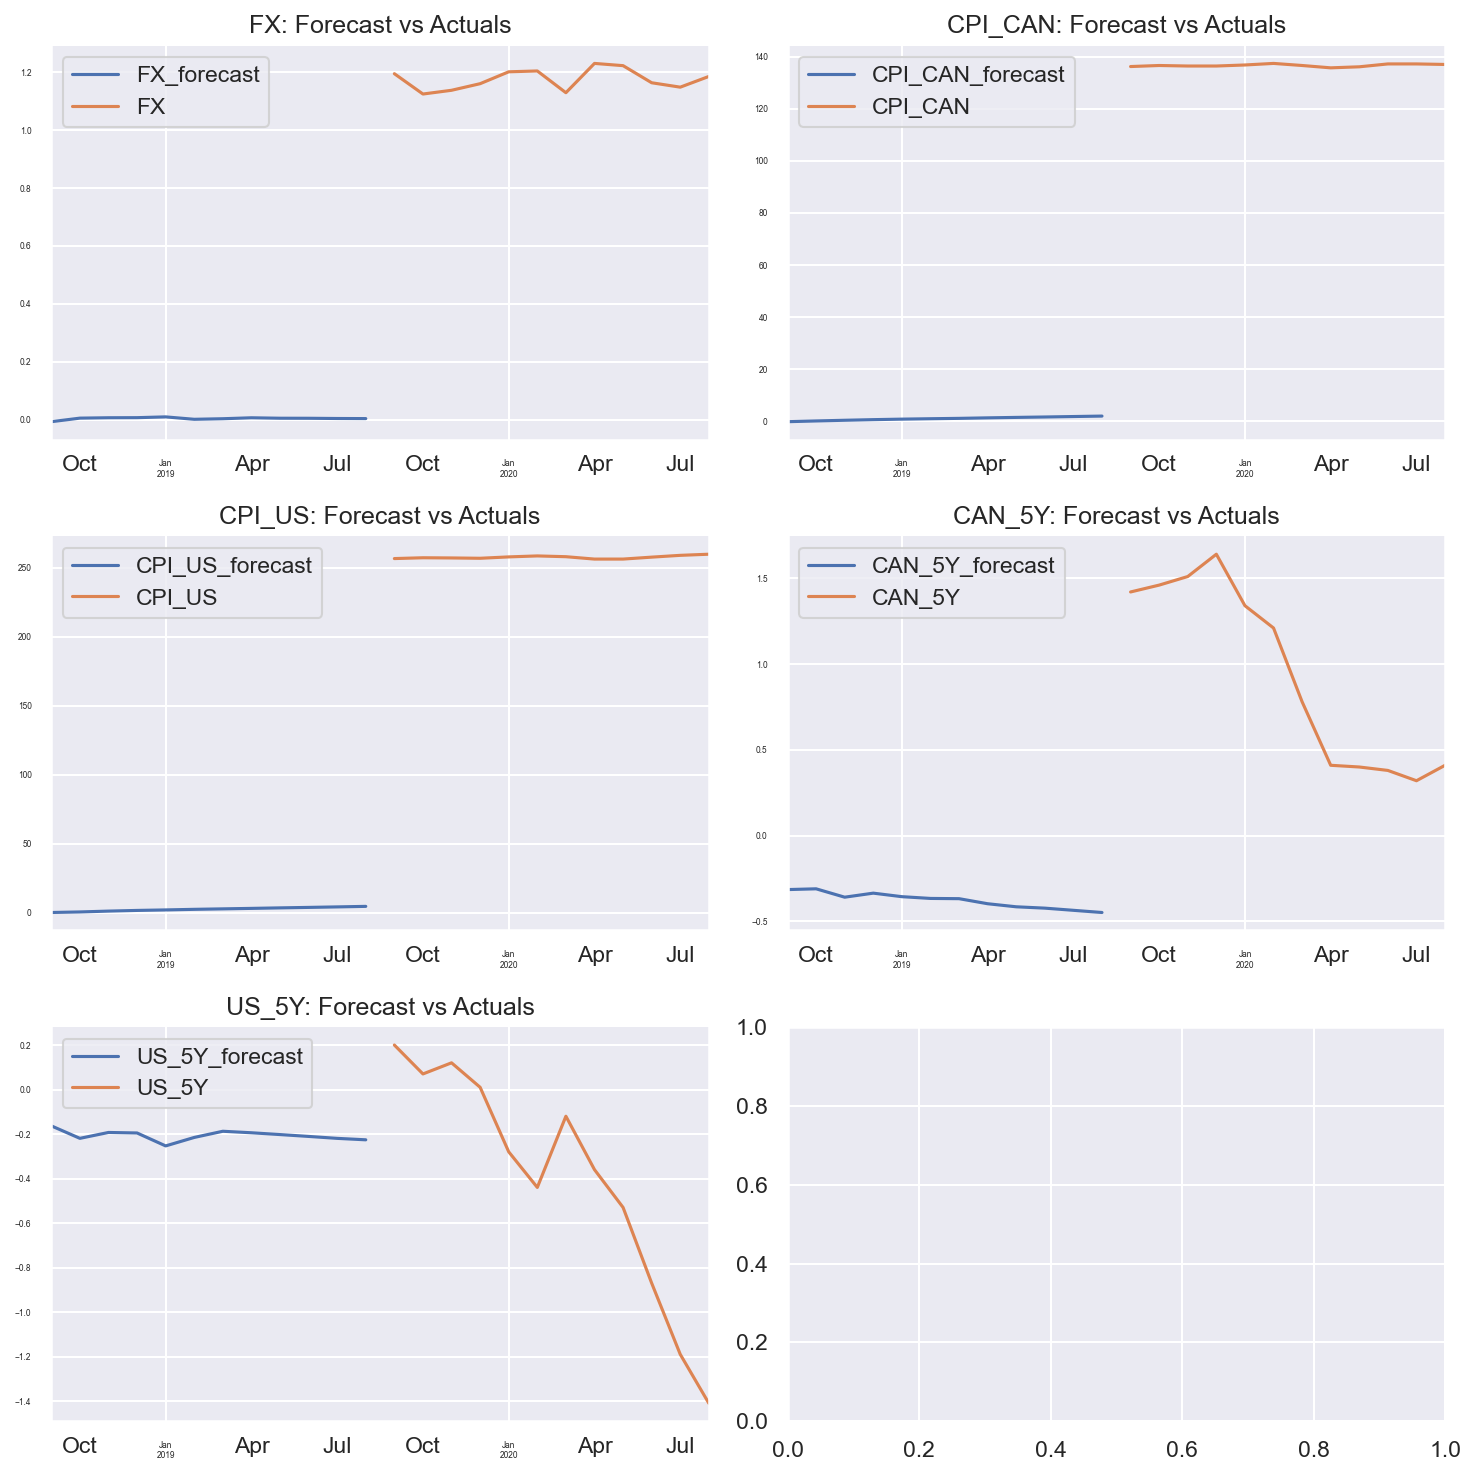

In [220]:
fig, axes = plt.subplots(
    nrows=int(len(df_differenced.columns) / 2 + 1), ncols=2, dpi=150, figsize=(10, 10)
)
for i, (col, ax) in enumerate(zip(df_differenced.columns, axes.flatten())):
    df_results[f"{col}_forecast"].plot(legend=True, ax=ax).autoscale(
        axis="x", tight=True
    )
    vecm_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=4)

plt.tight_layout()

### Comments

The VAR(4) model does not seem to explain well the dynamic of USDCAD exchange rate with PPP and UIRP